# Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports ########################################
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
# End notebooks specific imports ####################################

# Basic useful imports
import yaml
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.spatial import cKDTree

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# From alens_analysis
import alens_analysis as aa
import alens_analysis.chromatin as aac


# Locations
alens_data_path = Path.home() / 'projects/DATA/Spindle/'

graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

In [11]:
from scipy.spatial.transform import Rotation as R

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    # Normalize vectors
    vec1 = vec1 / np.linalg.norm(vec1)
    vec2 = vec2 / np.linalg.norm(vec2)

    # Compute the cross product and dot product
    cross_prod = np.cross(vec1, vec2)
    dot_prod = np.dot(vec1, vec2)

    # Compute the rotation angle
    angle = np.arccos(dot_prod)

    # Compute the rotation axis
    axis = cross_prod / np.linalg.norm(cross_prod)

    # Use scipy to compute the rotation matrix
    rotation_vector = axis * angle
    rotation = R.from_rotvec(rotation_vector)
    rotation_matrix = rotation.as_matrix()

    return rotation_matrix

def make_pbc_points(pos, boxsize):
    pbc_points = []
    shift = [-1., 0., 1.]
    for i in shift:
        for j in shift:
            for k in shift:
                pbc_points.append(pos + np.array([i, j, k])* boxsize)
    return np.vstack(pbc_points)

def filter_ghost_particles(com_arr, n_arr):
    ghost_vec = np.array([0,0,0])
    mask = np.all(com_arr[:,:] == ghost_vec, axis=1)
    return com_arr[~mask], n_arr[~mask]

def nematic_lattice_coarse_grain(sy_dat, time=-1, distance=1.0, num_lattice_points=10, 
                         boxsize=None, shift=0.0, pbc=True):
    # Get data for analysis from hdf5 file formatted particles
    positions = .5 * (sy_dat[:, 2:5, time] + sy_dat[:, 5:8, time])
    n_arr = sy_dat[:, 5:8, time] - sy_dat[:, 2:5, time]
    n_arr /= np.linalg.norm(n_arr, axis=1)[:,None]

    x = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    y = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    z = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    xv, yv, zv = np.meshgrid(x, y, z)
    lattice_pos = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)

    # Create a KDTree for fast neighbor search
    lattice_tree = cKDTree(lattice_pos)
    
    if pbc:
        particle_pos = make_pbc_points(positions, boxsize)
        n_arr = np.tile(n_arr, (27, 1))
    else:
        particle_pos = positions

    particle_tree = cKDTree(particle_pos)

    # Cell query for coarse graining
    # pairs = lattice_tree.query_ball_tree(particle_tree, r=distance, p="infinity")

    # Sphereical query for coarse graining
    pairs = lattice_tree.query_ball_tree(particle_tree, r=distance, p=2)
    
    nem_order_arr = np.zeros((num_lattice_points**3))
    nem_director_arr = np.zeros((num_lattice_points**3, 3))
    density_arr = np.zeros((num_lattice_points**3))
    for cur_seg, neigh_inds in enumerate(pairs):
        # check to see if there are any neighbors
        if not neigh_inds:
            continue

        density_arr[cur_seg] = float(len(neigh_inds))
        neigh_n_arr = n_arr[neigh_inds,:]
        # Analyze nematic order of neighbors
        nem_order_arr[cur_seg], nem_director_arr[cur_seg,:] = aa.nematic_order.nematic_analysis(neigh_n_arr)

    return lattice_pos, nem_order_arr, nem_director_arr, density_arr


def zrho_corr(sy_dat, time=-1, distance=1.0, boxsize=None, shift=0.0, pbc=True):  
    # Get data for analysis from hdf5 file formatted particles
    # com_arr = .5 * (sy_dat[:, 2:5, time] + sy_dat[:, 5:8, time])
    com_arr = sy_dat[:, 2:5, time]
    n_arr = sy_dat[:, 5:8, time] - sy_dat[:, 2:5, time]
    n_arr /= np.linalg.norm(n_arr, axis=1)[:,None]

    positions, normals = filter_ghost_particles(com_arr[:,:], n_arr[:,:])

    # Create a KDTree for fast neighbor search
    tree = cKDTree(positions, boxsize=boxsize)
    
    if pbc:
        match_pos = make_pbc_points(positions, boxsize)
    else:
        match_pos = positions

    match_tree = cKDTree(match_pos)
    pairs = tree.query_ball_tree(match_tree, r=distance)
    
    zvec = np.array([0,0,1.])
    rot_neigh_pos_list = []
    for cur_seg, neigh_inds in enumerate(pairs):
        n_vec = normals[cur_seg,:] # Normal vector of current segment
        neigh_pos = match_pos[neigh_inds,:] - positions[cur_seg,:]

        # Apply pbc to neighbor positions. Indices have factored in pbc but not the positions
        if boxsize is not None:
            neigh_pos = neigh_pos - np.round(neigh_pos/boxsize)*boxsize
        
        # if normal is aligned in the z direction, no need to rotate
        if np.all(n_vec == zvec):
            rot_neigh_pos_list += [neigh_pos]
            continue

        # Rotation matrix that transforms current segments orientation to zvec
        rot_mat = rotation_matrix_from_vectors(n_vec, zvec)
        # Rotate all neighbors to align with current zvec
        rot_neigh_pos_list += [np.einsum('ij,kj->ki', rot_mat, neigh_pos)]

    rot_neigh_pos_arr = np.vstack(rot_neigh_pos_list)

    # Create a boolean mask where True values correspond to rows that are equal to zero_vec
    # and apply it to rot_neigh_pos_arr to remove self counting
    zero_vec = np.array([0,0,0])
    mask = np.all(rot_neigh_pos_arr == zero_vec, axis=1)
    rot_neigh_pos_arr = rot_neigh_pos_arr[~mask]

    # Extract the dimensions you want
    rhopos = np.linalg.norm(rot_neigh_pos_arr[:,:2], axis=1)
    zpos = rot_neigh_pos_arr[:,2]
    return zpos, rhopos 

In [32]:
# make a list of points that sit on a 3d cubic lattice of n points
n = 15 
L = 5
x = np.linspace(0.0001, L, n, endpoint=False)
y = np.linspace(0.0001, L, n, endpoint=False)
z = np.linspace(0.0001, L, n, endpoint=False)
xv, yv, zv = np.meshgrid(x, y, z)

end0_points = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)
end1_points = end0_points + np.array([0.0, 1.0, 0.])
buffer = np.zeros((end0_points.shape[0], 2))
sy_dat = np.hstack([buffer, end0_points, end1_points])[:,:,np.newaxis]

boxsize = [5.001, 5.001, 5.001]

zpos, rhopos = zrho_corr(sy_dat, time=0, distance=4, boxsize=boxsize, pbc=False)

# zpos, rhopos = zrho_corr_new(matrix,points, distance=2.5, boxsize=5.001)
# zpos, rhopos = zrho_corr_new(matrix,points, distance=1.0, boxsize=[5.001,5.001,5.001])

11360250


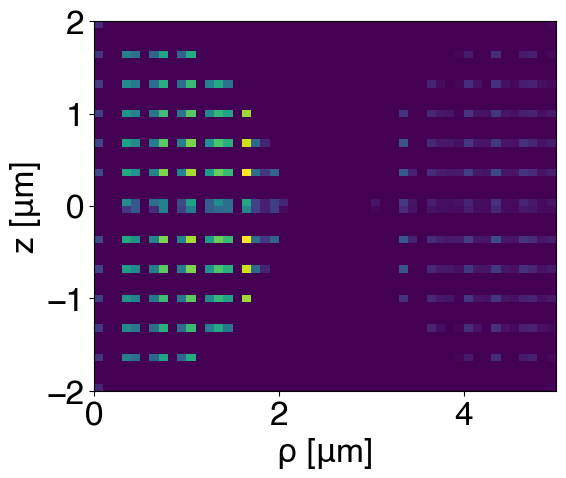

In [33]:
rhoarr1 = np.array(rhopos)
zarr1 = np.array(zpos)
print(len(rhoarr1))
heatmap1, rhoedges, zedges = np.histogram2d(rhoarr1, zarr1, bins=50, weights=1./(rhoarr1+ 1), range=[[0, 5], [-2, 2]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

_ = plt.clf()
_ = plt.imshow(heatmap1.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")

37781419


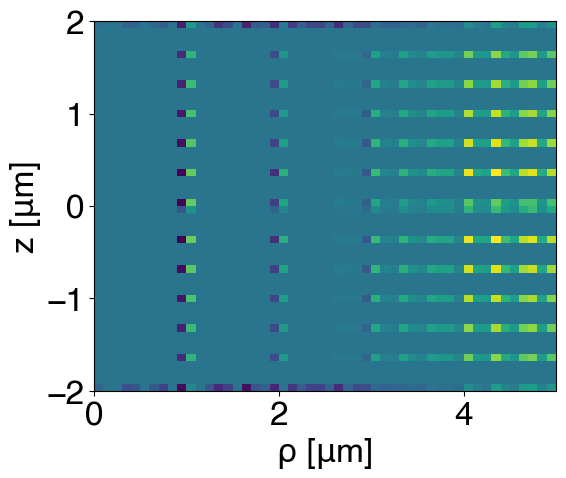

In [34]:
# make a list of points that sit on a 3d cubic lattice of n points
n = 15 
L = 5
x = np.linspace(0, L, n, endpoint=False)
y = np.linspace(0, L, n, endpoint=False)
z = np.linspace(0, L, n, endpoint=False)
xv, yv, zv = np.meshgrid(x, y, z)

end0_points = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)
end1_points = end0_points + np.array([0.0, 1.0, 0.])
buffer = np.zeros((end0_points.shape[0], 2))
sy_dat = np.hstack([buffer, end0_points, end1_points])[:,:,np.newaxis]

boxsize = [5.00, 5.00, 5.00]

zpos, rhopos = zrho_corr(sy_dat, time=0, distance=4, boxsize=boxsize)

# zpos, rhopos = zrho_corr_new(matrix,points, distance=2.5, boxsize=5.001)
# zpos, rhopos = zrho_corr_new(matrix,points, distance=1.0, boxsize=[5.001,5.001,5.001])
rhoarr = np.array(rhopos)
zarr = np.array(zpos)
print(len(rhoarr))
heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./(rhoarr+ 1), range=[[0, 5], [-2, 2]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

_ = plt.clf()
_ = plt.imshow(heatmap.T - heatmap1.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")